In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [2]:
data  = pd.read_csv("C:/Users/saiga/Desktop/RF_Incidents_Merged.csv")

C:\Users\saiga\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


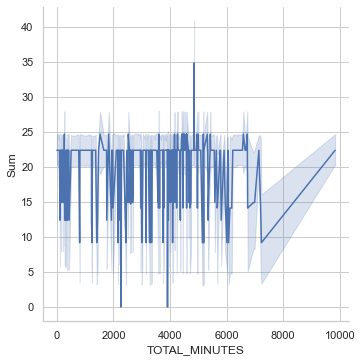

In [3]:
 sns.relplot(x="TOTAL_MINUTES", y="Sum", kind="line", data=data)
plt.show()

In [5]:
df = data.drop(['LAT',
 'LON',
 '25-Aug',
 '26-Aug',
 '27-Aug',
 '28-Aug',
 '29-Aug',
 '30-Aug',
 '31-Aug','ENTER_DATE',
 'ENTER_TIME',
 'CLEAR_DATE',
 'CLEAR_TIME','County',
 'ROADWAY_NAME',
 'LATITUDE_IB_CW',
 'LATITUDE_OB_CCW',
 'LONGITUDE_IB_CW',
 'LONGITUDE_OB_CCW',
 'COUNTY_NAME','Totals','IsSum_Total_Same?'],axis =1)
df.head()

,Sum,elev_meters_x,TOTAL_MINUTES,elev_meters_y
0,0.00,-0.45,0,10.1
1,5.55,41.13,0,10.1
2,0.00,26.93,0,10.1
3,33.44,27.84,0,10.1
4,0.23,26.93,0,10.1


In [35]:
df["Sum"].corr(df["TOTAL_MINUTES"])

-0.003773322468770846

<AxesSubplot:>

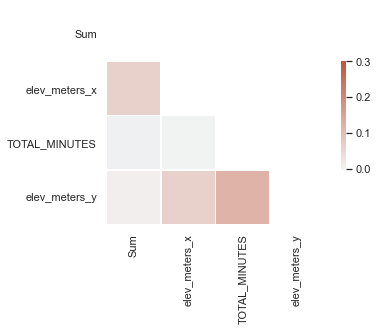

In [79]:
# f = plt.figure(figsize=(19, 15))
# plt.matshow(df.corr(), fignum=f.number)
# plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
# plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
# cb = plt.colorbar()
# cb.ax.tick_params(labelsize=14)
# plt.title('Correlation Matrix', fontsize=16)

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
mask = np.triu(np.ones_like(df.corr(), dtype=bool))
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(df.corr(), mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [38]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,Sum,elev_meters_x,TOTAL_MINUTES,elev_meters_y
Sum,1.000000,0.063355,-0.003773,0.005749
elev_meters_x,0.063355,1.000000,-0.001076,0.061932
TOTAL_MINUTES,-0.003773,-0.001076,1.000000,0.120383
elev_meters_y,0.005749,0.061932,0.120383,1.000000


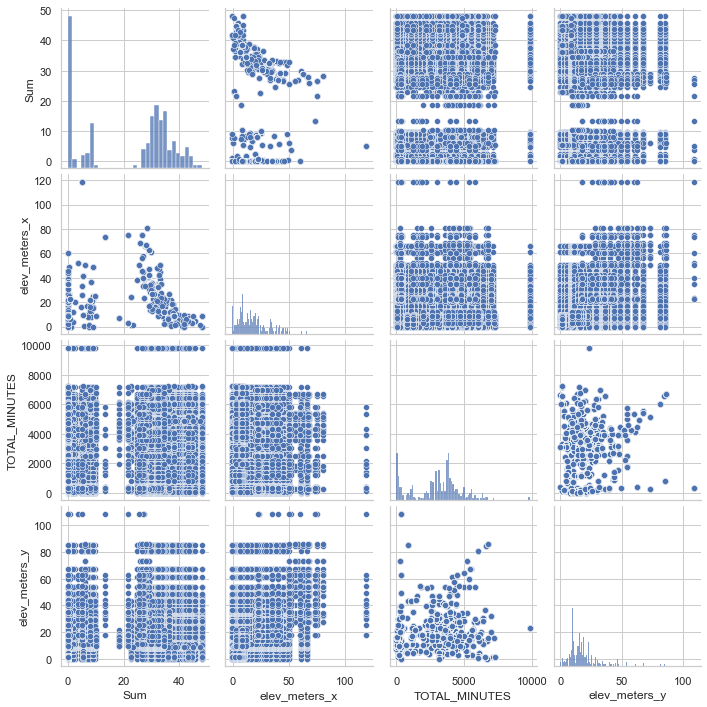

In [80]:
# pd.plotting.scatter_matrix(df, alpha=0.2)
sns.pairplot(df)

In [43]:
X = df.loc[:, df.columns != 'Sum']
y = df.loc[:, df.columns == 'Sum']/df["Sum"].abs().max()
y.head()

,Sum
0,0.000000
1,0.115145
2,0.000000
3,0.693776
4,0.004772


In [44]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [59]:
y=pd.DataFrame(le.fit_transform(y),columns=['target'])
le.classes_.size
y.head()

C:\Users\saiga\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


,target
0,0
1,17
2,0
3,108
4,3


In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
columns = X_train.columns

In [61]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

In [62]:
std = preprocessing.StandardScaler()
X_std = std.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X.columns

Index(['elev_meters_x', 'TOTAL_MINUTES', 'elev_meters_y'], dtype='object')

In [63]:
lr = LinearRegression()
X_std = std.fit_transform(X_train)
lr.fit(X_train,y_train)
rfe = RFE(lr,n_features_to_select=10)
rfe = rfe.fit(X_std, y_train)
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('elev_meters_x', True, 1),
 ('TOTAL_MINUTES', True, 1),
 ('elev_meters_y', True, 1)]

In [64]:
from sklearn import metrics
y_pred = rfe.predict(X_test)
mse = metrics.mean_squared_error(y_test, y_pred)
r2 = metrics.r2_score(y_test, y_pred)
print(r2)
mse
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test,(np.rint(y_pred)).astype(int))


-266.66063423694396


851834.0600609314

In [65]:
lm = LinearRegression()
scores = cross_val_score(lr, X_train, y_train, scoring='r2', cv=5)
scores   

array([0.00930968, 0.00786714, 0.00636978, 0.00796621, 0.01038392])

In [66]:
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)
scores = cross_val_score(lm, X_train, y_train, scoring='r2', cv=folds)
scores  

array([0.01015667, 0.00507013, 0.00893498, 0.00878837, 0.00790799])

In [67]:
scores = cross_val_score(lm, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
scores

array([-3136.40897578, -3115.80250745, -3160.94000542, -3124.80511334,
       -3171.33246696])

In [68]:
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

# step-2: specify range of hyperparameters to tune
hyper_params = [{'n_features_to_select': list(range(1, 14))}]


# step-3: perform grid search
# 3.1 specify model
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm)             

# 3.2 call GridSearchCV()
model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(X_train, y_train)  

Fitting 5 folds for each of 13 candidates, totalling 65 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=RFE(estimator=LinearRegression()),
             param_grid=[{'n_features_to_select': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13]}],
             return_train_score=True, scoring='r2', verbose=1)

In [69]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.010721,0.003138,0.001200,0.000980,1,{'n_features_to_select': 1},0.010349,0.005171,0.008893,0.008755,...,0.008258,0.001707,1,0.008033,0.009283,0.008426,0.008392,0.008479,0.008523,0.000411
1,0.003125,0.006250,0.003124,0.006248,2,{'n_features_to_select': 2},0.010281,0.005026,0.008891,0.008750,...,0.008210,0.001743,2,0.008044,0.009295,0.008427,0.008393,0.008483,0.008529,0.000413
2,0.003125,0.006250,0.003125,0.006250,3,{'n_features_to_select': 3},0.010157,0.005070,0.008935,0.008788,...,0.008172,0.001708,3,0.008089,0.009298,0.008430,0.008405,0.008540,0.008552,0.000402
3,0.008257,0.004269,0.001199,0.000979,4,{'n_features_to_select': 4},0.010157,0.005070,0.008935,0.008788,...,0.008172,0.001708,3,0.008089,0.009298,0.008430,0.008405,0.008540,0.008552,0.000402
4,0.006252,0.007658,0.003125,0.006250,5,{'n_features_to_select': 5},0.010157,0.005070,0.008935,0.008788,...,0.008172,0.001708,3,0.008089,0.009298,0.008430,0.008405,0.008540,0.008552,0.000402
5,0.006248,0.007652,0.003124,0.006249,6,{'n_features_to_select': 6},0.010157,0.005070,0.008935,0.008788,...,0.008172,0.001708,3,0.008089,0.009298,0.008430,0.008405,0.008540,0.008552,0.000402
6,0.009375,0.007654,0.000000,0.000000,7,{'n_features_to_select': 7},0.010157,0.005070,0.008935,0.008788,...,0.008172,0.001708,3,0.008089,0.009298,0.008430,0.008405,0.008540,0.008552,0.000402
7,0.006249,0.007654,0.003125,0.006250,8,{'n_features_to_select': 8},0.010157,0.005070,0.008935,0.008788,...,0.008172,0.001708,3,0.008089,0.009298,0.008430,0.008405,0.008540,0.008552,0.000402
8,0.009375,0.007655,0.000000,0.000000,9,{'n_features_to_select': 9},0.010157,0.005070,0.008935,0.008788,...,0.008172,0.001708,3,0.008089,0.009298,0.008430,0.008405,0.008540,0.008552,0.000402
9,0.006250,0.007655,0.006250,0.007655,10,{'n_features_to_select': 10},0.010157,0.005070,0.008935,0.008788,...,0.008172,0.001708,3,0.008089,0.009298,0.008430,0.008405,0.008540,0.008552,0.000402


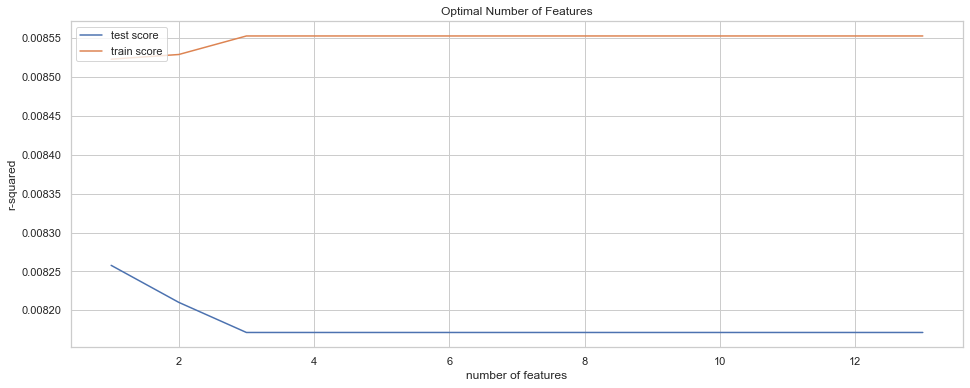

In [70]:
plt.figure(figsize=(16,6))

plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')

In [74]:
# final model
n_features_optimal = 12

lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=n_features_optimal)             
rfe = rfe.fit(X_train, y_train)

# predict prices of X_test
y_pred = lm.predict(X_test)
r2 = metrics.r2_score(y_test, y_pred)
print(r2)

0.008807542201034635
